In [1]:
import copy
import os
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append('..')
from utils.nn import FFNN

In [2]:
DATA = '../daily/data'
N_MODS = 3

True


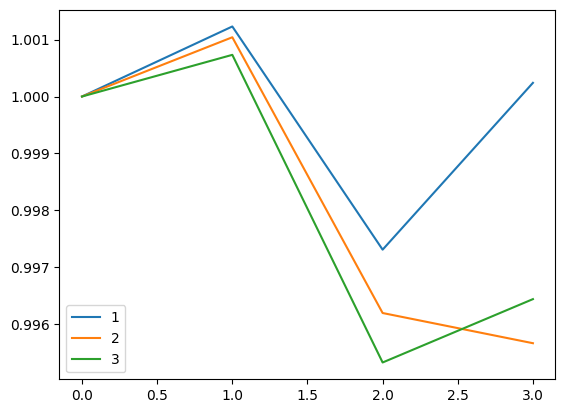

In [3]:
N_NEEDED = 4
N_AT_TOP = 2

perf1 = np.array([99884])
perf2 = np.array([99357])
perf3 = np.array([99261])

MUTATE = len(perf1) - 1 >= N_NEEDED
print(MUTATE)

buying_power = [168612, 174781, 175416]

plt.plot(perf1 / perf1[0], label='1')
plt.plot(perf2 / perf2[0], label='2')
plt.plot(perf3 / perf3[0], label='3')
plt.legend();

In [4]:
BEST = 2  # [1, 2, 3]
MUTATE_SCALE = 0.5

In [5]:
metrics = pd.read_csv(f'{DATA}/stock_metrics.csv')
metrics.head()

,stock,price,direction,RSI,RSIRev,fair_value_mult,geomean,sharpe
0,AAON,82.070000,0,0.042366,0.957634,0.074722,0.013796,0.680052
1,AAPL,239.070007,1,0.388090,0.611910,0.402226,0.277592,0.893353
2,ABBV,214.289993,1,0.962430,0.037570,0.955087,0.838211,0.803532
3,ABNB,134.389999,0,0.235238,0.764762,0.131579,0.439362,0.208091
4,ABT,137.139999,1,0.774980,0.225020,0.712242,0.807692,0.654325


In [6]:
x = metrics[['direction', 'RSI', 'fair_value_mult', 'geomean', 'sharpe']]

In [7]:
states = [None] * N_MODS
try:
    with open(f'{DATA}/ffnn_states.pkl', 'rb') as f:
        states = pickle.load(f)
        print('States recovered')
except FileNotFoundError:
    print('Creating new states...')
    states = [None] * N_MODS

States recovered


In [8]:
len(states)

3

In [9]:
mods = []
for state in states:
    mod = FFNN(**state) if state is not None else FFNN(5, [5])
    mods.append(mod)

In [10]:
if MUTATE:
    print('mutating..')
    best_state = mods[BEST - 1].get_state()
    mods = [mods[BEST - 1]]

    for _ in range(1, N_MODS):
        new_mod = FFNN(**copy.deepcopy(best_state))
        new_mod.mutate(scale=MUTATE_SCALE)
        mods.append(new_mod)
else:
    print('do nothing')

mutating..


In [12]:
len(mods)

3

In [13]:
#for mod in mods:
#    print(mod.Ws)

In [14]:
def get_holdings(filename, i):
    df = pd.read_csv(f'~/Downloads/ffnn/{filename}')
    df = df[['Symbol', 'Value']]
    df.Value = df.Value.str.replace('$', '').str.replace(',', '').astype(float)
    df.columns = ['stock', f'holdings{i + 1}']
    df.set_index('stock', drop=True, inplace=True)
    return df

In [15]:
holdings_files = sorted([f for f in os.listdir('/Users/damiansp/Downloads/ffnn') if f.endswith('.csv')])
holdings = pd.concat([get_holdings(f, i) for i, f in enumerate(holdings_files)], axis=1)
holdings.fillna(0, inplace=True)
holdings.head()

,holdings1,holdings2,holdings3
stock,,,
ABBV,642.87,0.00,0.00
ABT,548.56,0.00,0.00
AJG,648.00,0.00,0.00
AMZN,597.75,597.75,597.75
AVGO,779.84,389.92,584.88


In [16]:
out = pd.DataFrame({'stock': metrics.stock, 'price': metrics.price.round(2)})
cols = []
for i, mod in enumerate(mods):
    value = mod.forward_pass(x, 'relu', 'sigmoid')
    value = value.squeeze()
    value /= np.sum(value)
    col = pd.Series(value, name=f'val{i + 1}')
    cols.append(col)
out = pd.concat([out, *cols], axis=1)
out.head()

,stock,price,val1,val2,val3
0,AAON,82.07,0.002913,0.002745,0.002830
1,AAPL,239.07,0.002926,0.002755,0.003089
2,ABBV,214.29,0.002847,0.002755,0.003066
3,ABNB,134.39,0.002809,0.002687,0.002414
4,ABT,137.14,0.002862,0.002752,0.003064


In [17]:
for h in [1, 2, 3]:
    invested_amt = holdings[f'holdings{h}'].sum()
    buying_power[h - 1] += invested_amt
print(buying_power)
amt_in = []
for i, d in enumerate(buying_power):
    amt = (d * out[f'val{i + 1}']).round(2)
    amt_in.append(pd.Series(amt, name=f'amt{i + 1}'))
out = pd.concat([out, *amt_in], axis=1)
out.set_index('stock', inplace=True, drop=True)
out.head()

[199768.53, 198714.64, 198522.04]


,price,val1,val2,val3,amt1,amt2,amt3
stock,,,,,,,
AAON,82.07,0.002913,0.002745,0.002830,581.99,545.54,561.72
AAPL,239.07,0.002926,0.002755,0.003089,584.56,547.41,613.21
ABBV,214.29,0.002847,0.002755,0.003066,568.76,547.54,608.76
ABNB,134.39,0.002809,0.002687,0.002414,561.06,533.85,479.16
ABT,137.14,0.002862,0.002752,0.003064,571.73,546.86,608.34


In [18]:
out = pd.concat([out, holdings], axis=1)
out.fillna(0, inplace=True)
out.head()

,price,val1,val2,val3,amt1,amt2,amt3,holdings1,holdings2,holdings3
stock,,,,,,,,,,
AAON,82.07,0.002913,0.002745,0.002830,581.99,545.54,561.72,0.00,0.0,0.0
AAPL,239.07,0.002926,0.002755,0.003089,584.56,547.41,613.21,0.00,0.0,0.0
ABBV,214.29,0.002847,0.002755,0.003066,568.76,547.54,608.76,642.87,0.0,0.0
ABNB,134.39,0.002809,0.002687,0.002414,561.06,533.85,479.16,0.00,0.0,0.0
ABT,137.14,0.002862,0.002752,0.003064,571.73,546.86,608.34,548.56,0.0,0.0


In [19]:
for i in range(N_MODS):
    out[f'diff{i + 1}'] = out[f'amt{i + 1}'] - out[f'holdings{i + 1}']
out.head()

,price,val1,val2,val3,amt1,amt2,amt3,holdings1,holdings2,holdings3,diff1,diff2,diff3
stock,,,,,,,,,,,,,
AAON,82.07,0.002913,0.002745,0.002830,581.99,545.54,561.72,0.00,0.0,0.0,581.99,545.54,561.72
AAPL,239.07,0.002926,0.002755,0.003089,584.56,547.41,613.21,0.00,0.0,0.0,584.56,547.41,613.21
ABBV,214.29,0.002847,0.002755,0.003066,568.76,547.54,608.76,642.87,0.0,0.0,-74.11,547.54,608.76
ABNB,134.39,0.002809,0.002687,0.002414,561.06,533.85,479.16,0.00,0.0,0.0,561.06,533.85,479.16
ABT,137.14,0.002862,0.002752,0.003064,571.73,546.86,608.34,548.56,0.0,0.0,23.17,546.86,608.34


In [20]:
out = out[((out.price.notnull()) & (out.price > 0))]

In [21]:
for i in range(N_MODS):
    out[f'shares{i + 1}'] = (out[f'diff{i + 1}'] / out.price).round().astype('Int64')
out = out[out.price >= 2]
out

,price,val1,val2,val3,amt1,amt2,amt3,holdings1,holdings2,holdings3,diff1,diff2,diff3,shares1,shares2,shares3
stock,,,,,,,,,,,,,,,,
AAON,82.07,0.002913,0.002745,0.002830,581.99,545.54,561.72,0.00,0.0,0.00,581.99,545.54,561.72,7,7,7
AAPL,239.07,0.002926,0.002755,0.003089,584.56,547.41,613.21,0.00,0.0,0.00,584.56,547.41,613.21,2,2,3
ABBV,214.29,0.002847,0.002755,0.003066,568.76,547.54,608.76,642.87,0.0,0.00,-74.11,547.54,608.76,0,3,3
ABNB,134.39,0.002809,0.002687,0.002414,561.06,533.85,479.16,0.00,0.0,0.00,561.06,533.85,479.16,4,4,4
ABT,137.14,0.002862,0.002752,0.003064,571.73,546.86,608.34,548.56,0.0,0.00,23.17,546.86,608.34,0,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
XYL,130.62,0.002833,0.002751,0.003062,565.96,546.61,607.94,0.00,0.0,0.00,565.96,546.61,607.94,4,4,5
ZBRA,292.69,0.002881,0.002731,0.002515,575.55,542.66,499.35,0.00,0.0,0.00,575.55,542.66,499.35,2,2,2
ZG,73.85,0.002790,0.002730,0.002979,557.31,542.47,591.39,0.00,0.0,0.00,557.31,542.47,591.39,8,7,8


In [22]:
o = out.sort_values('diff1', ascending=False)[['price', 'diff1', 'shares1']]
o[o.shares1 != 0].head(10)

,price,diff1,shares1
stock,,,
GRMN,219.34,592.53,3
HWM,124.40,592.41,5
MASI,174.52,592.22,3
CRWD,333.50,591.71,2
ANET,83.36,591.69,7
HUBS,640.21,591.66,1
ARES,154.96,591.66,4
SPOT,532.10,591.62,1
MSFT,393.31,591.32,2


In [23]:
o[o.shares1 != 0].tail(10)

,price,diff1,shares1
stock,,,
MO,57.79,-91.37,-2
SMCI,38.24,-95.43,-2
JBL,139.95,-108.16,-1
ED,103.64,-111.66,-1
QTUM,78.53,-113.83,-1
RGTI,9.35,-120.10,-13
CELH,27.39,-123.08,-4
JNJ,166.69,-144.01,-1
AVGO,194.96,-186.92,-1


In [24]:
o = out.sort_values('diff2', ascending=False)[['price', 'diff2', 'shares2']]
o[o.shares2 != 0].head(10)

,price,diff2,shares2
stock,,,
AJG,324.00,547.87,2
BRO,118.65,547.87,5
CWAY,28.24,547.64,19
MSFT,393.31,547.57,1
ABBV,214.29,547.54,3
MCD,321.29,547.50,2
EP,6.81,547.50,80
DE,499.62,547.47,1
MSCI,561.89,547.47,1


In [25]:
o[o.shares2 != 0].tail(10)

,price,diff2,shares2
stock,,,
CELH,27.39,191.60,7
AVGO,194.96,157.78,1
CTAS,203.06,141.72,1
LFMD,4.67,-13.30,-3
SMCI,38.24,-26.34,-1
FTNT,101.28,-60.04,-1
HWM,124.40,-74.70,-1
LRCX,79.01,-84.74,-1
RGTI,9.35,-88.95,-10


In [26]:
o = out.sort_values('diff3', ascending=False)[['price', 'diff3', 'shares3']]
o[o.shares3 != 0].head(10)

,price,diff3,shares3
stock,,,
AJG,324.00,616.67,2
COST,964.31,616.43,1
PGR,279.82,615.73,2
CPRT,53.74,615.72,11
KNSL,446.27,615.42,1
GRMN,219.34,614.78,3
TMUS,265.24,614.51,2
TTWO,204.33,614.47,3
MASI,174.52,614.33,4


In [27]:
o[o.shares3 != 0].tail(10)

,price,diff3,shares3
stock,,,
WIT,3.26,44.71,14
BYRN,22.48,41.23,2
SMCI,38.24,41.20,1
BROS,63.86,39.33,1
BYND,3.36,33.87,10
RCAT,5.39,28.27,5
VTRS,9.65,16.67,2
RIVN,11.17,-21.38,-2
COUR,7.14,-22.71,-3


In [28]:
if MUTATE:
    states = [mod.get_state() for mod in mods]
    with open(f'{DATA}/ffnn_states.pkl', 'wb') as f:
        pickle.dump(states, f)
    print('States saved')
else:
    print('Did nothing')

States saved
